## Initial Setup

In [32]:
import os
datapath = os.path.join("dataset", "home-credit-default-risk")

# Import and settings for plotings figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Import panda
import pandas as pd
pd.set_option('display.max_columns', 500)

# Create a function to load the dataset into a panda object
def load_dataset(filename, path=datapath):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

# Import numpy
import numpy as np

## Load Dataset

In [33]:
app_train = load_dataset("application_train.csv")
app_test = load_dataset("application_test.csv")
print("app_test shape: ", app_train.shape)
print("app_test shape: ", app_test.shape)

app_test shape:  (307511, 122)
app_test shape:  (48744, 121)


## Data Pre Processing

### Fixing anomalies

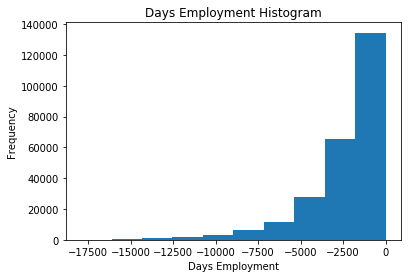

In [34]:
import numpy as np

app_train['DAYS_EMPLOYED_ANOM'] = (app_train["DAYS_EMPLOYED"] == 365243)


app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [35]:
app_test['DAYS_EMPLOYED_ANOM'] = (app_test['DAYS_EMPLOYED'] == 365243)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

### Encoding

**Label encoding**

In [36]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            labelEncoder.fit(app_train[col])

            app_train[col] = labelEncoder.transform(app_train[col])
            app_test[col] = labelEncoder.transform(app_test[col])
            
            count += 1
            
print('%d columns were label encoded.' % count)

3 columns were label encoded.


**one-hot encoding**

In [37]:
print('before training shape: ', app_train.shape)
print('before test shape: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('after training shape: ', app_train.shape)
print('after test shape: ', app_test.shape)


before training shape:  (307511, 123)
before test shape:  (48744, 122)
after training shape:  (307511, 244)
after test shape:  (48744, 240)


In [38]:
# Save training target labels
train_labels = app_train['TARGET']

# Align the training and testing data
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)


### Missing values and Features Scaling

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
])

In [40]:
train = pipeline.fit_transform(app_train.drop(['TARGET', 'SK_ID_CURR'], axis = 1))
test = pipeline.fit_transform(app_test.drop(['SK_ID_CURR'], axis = 1))
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 239)


## Modeling - Base Scenario

## Logistic Regression (Cross Validated)

In [15]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="liblinear", random_state=10)

In [16]:
from sklearn.model_selection import cross_val_predict

labels_prob_lr = cross_val_predict(log_reg, train, train_labels, cv=6, 
                                method="predict_proba")

**ROC Curve**

In [41]:
from sklearn.metrics import roc_curve

In [18]:
from sklearn.metrics import roc_curve
# TPR: True Positive Rate
# FPR: False Positive Rate
fpr_lr, tpr_lr, thresholds_lr = roc_curve(train_labels, labels_prob_lr[:,1])

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

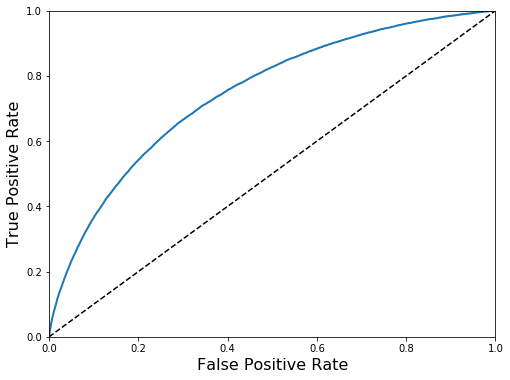

In [20]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lr, tpr_lr)
plt.show()

**Calculate AUC**

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_labels, labels_prob_lr[:,1])

0.7462548292758777

**Save metrics**

In [23]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_lr = np.c_[fpr_lr, tpr_lr, thresholds_lr]
metrics_lr = pd.DataFrame(metrics_lr, columns=metrics_names)
metrics_lr.to_csv('metrics_lr.csv')

label_names = list(['orig', 'prob'])
labels_lr = np.c_[train_labels, labels_prob_lr[:,1]]
labels_lr = pd.DataFrame(labels_lr, columns=label_names)
labels_lr.to_csv('labels_lr.csv')

## Random Forest (Cross Validated)

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=256, 
                                n_jobs=-1, random_state=10)

In [25]:
from sklearn.model_selection import cross_val_predict

labels_prob_rf = cross_val_predict(rf_clf, train, train_labels, cv=6, 
                                   method="predict_proba")

**ROC Curve**

In [26]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(train_labels, labels_prob_rf[:,1])

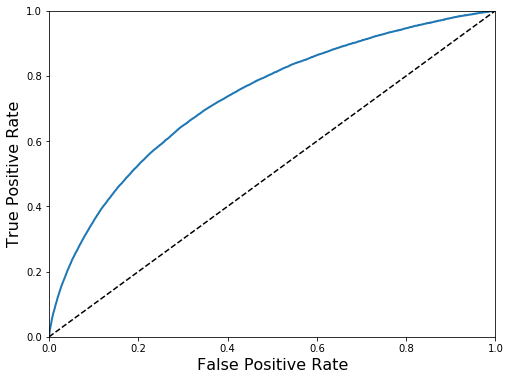

In [27]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_rf, tpr_rf)
plt.show()

**Calculate AUC**

In [28]:
roc_auc_score(train_labels, labels_prob_rf[:,1])

0.7323508875607815

**Save metrics**

In [29]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_rf = np.c_[fpr_rf, tpr_rf, thresholds_rf]
metrics_rf = pd.DataFrame(metrics_rf, columns=metrics_names)
metrics_rf.to_csv('metrics_rf.csv')

label_names = list(['orig', 'prob'])
labels_rf = np.c_[train_labels, labels_prob_rf[:,1]]
labels_rf = pd.DataFrame(labels_rf, columns=label_names)
labels_rf.to_csv('labels_rf.csv')

## Linear SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svm_clf = LinearSVC(C=1, loss="hinge", random_state=10, max_iter=5000)
cc_svm = CalibratedClassifierCV(base_estimator=svm_clf, method='sigmoid')

In [ ]:
cc_svm.fit(train, train_labels)

In [ ]:
labels_prob_lsvm = cc_svm.predict_proba(train)

**ROC Curve**

In [ ]:
fpr_lsvm, tpr_lsvm, thresholds_lsvm_ = roc_curve(
                    train_labels, labels_prob_lsvm[:,1])

In [ ]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lsvm, tpr_lsvm)
plt.show()

**Calculate AUC**

In [ ]:
roc_auc_score(train_labels, labels_prob_lsvm[:,1])

**Save metrics**

In [ ]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_lsvm = np.c_[fpr_lsvm, tpr_lsvm, thresholds_lsvm]
metrics_lsvm = pd.DataFrame(metrics_lsvm, columns=metrics_names)
metrics_lsvm.to_csv('metrics_lsvm.csv')

label_names = list(['orig', 'prob'])
labels_lsvm = np.c_[train_labels, labels_prob_lsvm[:,1]]
labels_lsvm = pd.DataFrame(labels_lsvm, columns=label_names)
labels_lsvm.to_csv('labels_lsvm.csv')

## Adaboost

In [115]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=250,
    algorithm="SAMME.R", learning_rate=0.5, random_state=10)

In [116]:
from sklearn.model_selection import cross_val_predict

labels_prob_ada = cross_val_predict(ada_clf, train, train_labels, cv=6, 
                                   method="predict_proba")

**ROC Curve**

In [117]:
fpr_ada, tpr_ada, thresholds_ada = roc_curve(
                    train_labels, labels_prob_ada[:,1])

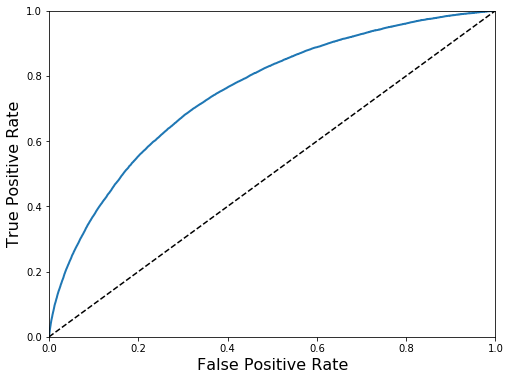

In [118]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_ada, tpr_ada)
plt.show()

**Calculate AUC**

In [119]:
roc_auc_score(train_labels, labels_prob_ada[:,1])

0.7520951117185104

**Save metrics**

In [120]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_ada = np.c_[fpr_ada, tpr_ada, thresholds_ada]
metrics_ada = pd.DataFrame(metrics_ada, columns=metrics_names)
metrics_ada.to_csv('metrics_ada.csv')

label_names = list(['orig', 'prob'])
labels_ada = np.c_[train_labels, labels_prob_ada[:,1]]
labels_ada = pd.DataFrame(labels_ada, columns=label_names)
labels_ada.to_csv('labels_ada.csv')

## Neural Network

**Split the training dataset into training and validation dataset**

In [121]:
X_valid, X_train = train[:50000], train[50000:]
y_valid, y_train = train_labels[:50000].values, train_labels[50000:].values

In [122]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [123]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

**Define network architecture parameters**

In [126]:
import tensorflow as tf

def reset_graph(seed=10):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

n_inputs = X_train.shape[1]  # number of features
n_hidden1 = 64
n_hidden2 = 64
n_hidden3 = 64
n_outputs = 2

In [127]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

**Buil the network with regularization**

In [128]:
scale = 0.001

In [129]:
from functools import partial
my_dense_layer = partial(
    tf.layers.dense, activation=leaky_relu,
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    hidden3 = my_dense_layer(hidden2, n_hidden3, name="hidden3")
    logits = my_dense_layer(hidden3, n_outputs, activation=None,
                            name="outputs")
    y_proba = tf.nn.softmax(logits)

In [130]:
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  
        labels=y, logits=logits)                                
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

**Select the AdamOptimizer**

In [131]:
learning_rate = 0.001

with tf.name_scope("train"):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
                                      
    training_op = optimizer.minimize(loss)

In [132]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [133]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

**Train the network**

In [134]:
n_epochs = 10
batch_size = 512

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, 
              "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./nn_base_model.ckpt")

0 Batch accuracy: 0.88671875 Validation accuracy: 0.91948
1 Batch accuracy: 0.92578125 Validation accuracy: 0.91948
2 Batch accuracy: 0.9277344 Validation accuracy: 0.91948
3 Batch accuracy: 0.9003906 Validation accuracy: 0.91948
4 Batch accuracy: 0.9160156 Validation accuracy: 0.91948
5 Batch accuracy: 0.9121094 Validation accuracy: 0.91948
6 Batch accuracy: 0.94140625 Validation accuracy: 0.91948
7 Batch accuracy: 0.92578125 Validation accuracy: 0.91948
8 Batch accuracy: 0.9238281 Validation accuracy: 0.91948
9 Batch accuracy: 0.9199219 Validation accuracy: 0.91948


In [135]:
with tf.Session() as sess:
    saver.restore(sess, "./nn_base_model.ckpt") 
    labels_prob_nn = y_proba.eval(feed_dict={X: X_valid})

INFO:tensorflow:Restoring parameters from ./nn_base_model.ckpt


**ROC curve**

In [136]:
fpr_nn, tpr_nn, thresholds_nn = roc_curve(
                    y_valid, labels_prob_nn[:,1])

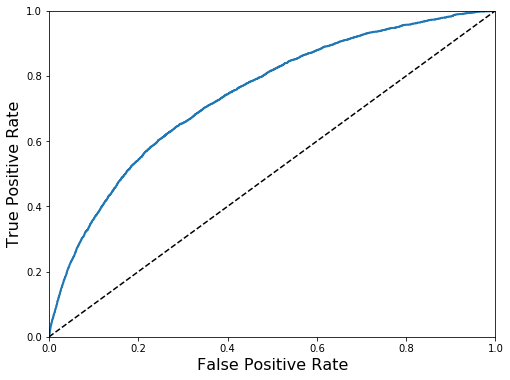

In [137]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_nn, tpr_nn)
plt.show()

**Calculate AUC**

In [138]:
roc_auc_score(y_valid, labels_prob_nn[:,1])

0.7419321258947824

**Save Metrics**

In [139]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_nn = np.c_[fpr_nn, tpr_nn, thresholds_nn]
metrics_nn = pd.DataFrame(metrics_nn, columns=metrics_names)
metrics_nn.to_csv('metrics_nn.csv')

label_names = list(['orig', 'prob'])
labels_nn = np.c_[y_valid, labels_prob_nn[:,1]]
labels_nn = pd.DataFrame(labels_nn, columns=label_names)
labels_nn.to_csv('labels_nn.csv')

## Random Forest to capture feature importance

In [140]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_ = RandomForestClassifier(n_estimators=500, max_leaf_nodes=256, 
                                 n_jobs=-1, random_state=10)

In [141]:
rf_clf_.fit(train, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=256,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [142]:
labels_prob_rf_ = rf_clf_.predict_proba(train)

In [143]:
fpr_rf_, tpr_rf_, thresholds_rf_ = roc_curve(
                    train_labels, labels_prob_rf_[:,1])

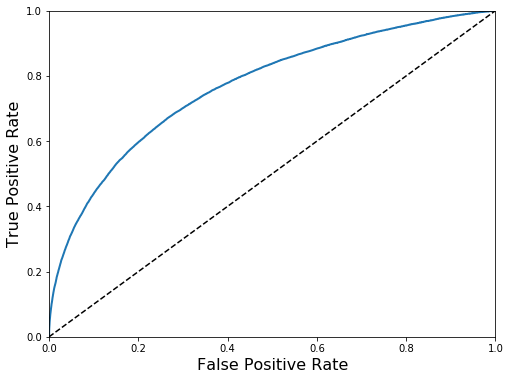

In [144]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_rf_, tpr_rf_)
plt.show()

In [145]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_labels, labels_prob_rf_[:,1])

0.7688475382807961

**Feature Importance**

In [146]:
feature_names = list(app_train.drop(['TARGET','SK_ID_CURR'],  axis = 1))
feature_importance_values = rf_clf_.feature_importances_

In [147]:
feature_importances = pd.DataFrame({'feature': feature_names, 
                            'importance': feature_importance_values})

In [148]:
feature_importances = feature_importances.sort_values('importance', 
        ascending = False).reset_index().drop(['index'], axis=1)

In [149]:
feature_importances.head(20)

,feature,importance
0,EXT_SOURCE_3,0.173453
1,EXT_SOURCE_2,0.166004
2,EXT_SOURCE_1,0.057938
3,DAYS_EMPLOYED,0.044781
4,DAYS_BIRTH,0.035080
5,DAYS_LAST_PHONE_CHANGE,0.024248
6,AMT_GOODS_PRICE,0.024021
7,AMT_CREDIT,0.020687
8,DAYS_ID_PUBLISH,0.018970
9,AMT_ANNUITY,0.016760


In [150]:
feature_importances.to_csv('feature_importances_rf.csv')